Problem 1 - Creating a 2-D convolutional layer

Conv1d Class

In [5]:
import numpy as np

class Conv1d:
    def __init__(self, input_channels, output_channels, kernel_size, stride=1, padding=0):
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        # Initialize weights and biases
        self.weights = np.random.randn(output_channels, input_channels, kernel_size) * 0.01
        self.biases = np.zeros(output_channels)

    def forward(self, x):
        # Apply padding to the input
        if self.padding > 0:
            x = np.pad(x, ((0, 0), (self.padding, self.padding)), mode='constant', constant_values=0)

        n_samples, in_channels, in_width = x.shape
        out_width = (in_width - self.kernel_size + 2 * self.padding) // self.stride + 1
        output = np.zeros((n_samples, self.output_channels, out_width))

        for i in range(n_samples):
            for m in range(self.output_channels):
                for j in range(out_width):
                    start = j * self.stride
                    end = start + self.kernel_size
                    region = x[i, :, start:end]
                    output[i, m, j] = np.sum(region * self.weights[m]) + self.biases[m]

        return output

    def backward(self, x, grad_output, learning_rate):
        n_samples, in_channels, in_width = x.shape
        grad_weights = np.zeros_like(self.weights)
        grad_biases = np.zeros_like(self.biases)
        grad_input = np.zeros_like(x)

        for i in range(n_samples):
            for m in range(self.output_channels):
                for j in range(grad_output.shape[2]):
                    start = j * self.stride
                    end = start + self.kernel_size
                    region = x[i, :, start:end]

                    grad_output_value = grad_output[i, m, j]

                    grad_weights[m] += grad_output_value * region
                    grad_biases[m] += grad_output_value
                    grad_input[i, :, start:end] += grad_output_value * self.weights[m]

        # Update weights and biases
        self.weights -= learning_rate * grad_weights
        self.biases -= learning_rate * grad_biases

        return grad_input


Conv2d Class

In [6]:
class Conv2d:
    def __init__(self, input_channels, output_channels, kernel_size, stride=1, padding=0):
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        # Initialize weights and biases
        self.weights = np.random.randn(output_channels, input_channels, kernel_size, kernel_size) * 0.01
        self.biases = np.zeros(output_channels)

    def forward(self, x):
        # Apply padding to the input
        if self.padding > 0:
            x = np.pad(x, ((0, 0), (0, 0), (self.padding, self.padding), (self.padding, self.padding)), mode='constant', constant_values=0)

        n_samples, in_channels, in_height, in_width = x.shape
        out_height = (in_height - self.kernel_size + 2 * self.padding) // self.stride + 1
        out_width = (in_width - self.kernel_size + 2 * self.padding) // self.stride + 1
        output = np.zeros((n_samples, self.output_channels, out_height, out_width))

        for i in range(n_samples):
            for m in range(self.output_channels):
                for j in range(out_height):
                    for k in range(out_width):
                        start_h = j * self.stride
                        start_w = k * self.stride
                        region = x[i, :, start_h:start_h+self.kernel_size, start_w:start_w+self.kernel_size]
                        output[i, m, j, k] = np.sum(region * self.weights[m]) + self.biases[m]

        return output

    def backward(self, x, grad_output, learning_rate):
        n_samples, in_channels, in_height, in_width = x.shape
        grad_weights = np.zeros_like(self.weights)
        grad_biases = np.zeros_like(self.biases)
        grad_input = np.zeros_like(x)

        for i in range(n_samples):
            for m in range(self.output_channels):
                for j in range(grad_output.shape[2]):
                    for k in range(grad_output.shape[3]):
                        start_h = j * self.stride
                        start_w = k * self.stride
                        region = x[i, :, start_h:start_h+self.kernel_size, start_w:start_w+self.kernel_size]

                        grad_output_value = grad_output[i, m, j, k]

                        grad_weights[m] += grad_output_value * region
                        grad_biases[m] += grad_output_value
                        grad_input[i, :, start_h:start_h+self.kernel_size, start_w:start_w+self.kernel_size] += grad_output_value * self.weights[m]

        # Update weights and biases
        self.weights -= learning_rate * grad_weights
        self.biases -= learning_rate * grad_biases

        return grad_input


Problem 2 - Experiments with 2D convolutional layers on small arrays

In [7]:
import numpy as np

class Conv2d:
    def __init__(self, weights, bias):
        # weights shape: (num_filters, num_channels, filter_height, filter_width)
        self.weights = weights
        self.bias = bias

    def forward(self, x):
        # x shape: (batch_size, num_channels, height, width)
        batch_size, num_channels, height, width = x.shape
        num_filters, _, filter_height, filter_width = self.weights.shape

        # Calculate output dimensions
        out_height = height - filter_height + 1
        out_width = width - filter_width + 1

        # Initialize output array
        out = np.zeros((batch_size, num_filters, out_height, out_width))

        # Perform convolution
        for b in range(batch_size):
            for f in range(num_filters):
                for i in range(out_height):
                    for j in range(out_width):
                        for c in range(num_channels):
                            # Extract the region of interest from input
                            region = x[b, c, i:i+filter_height, j:j+filter_width]
                            # Perform convolution (element-wise multiplication + sum)
                            out[b, f, i, j] += np.sum(region * self.weights[f, c]) + self.bias[f]
        return out

    def backward(self, x, delta):
        # x shape: (batch_size, num_channels, height, width)
        # delta shape: (batch_size, num_filters, out_height, out_width)
        batch_size, num_channels, height, width = x.shape
        num_filters, _, filter_height, filter_width = self.weights.shape

        # Initialize gradients with float64 type
        dW = np.zeros_like(self.weights, dtype=np.float64)
        dB = np.zeros_like(self.bias, dtype=np.float64)
        dx = np.zeros_like(x, dtype=np.float64)

        # Perform backpropagation
        for b in range(batch_size):
            for f in range(num_filters):
                for i in range(delta.shape[2]):
                    for j in range(delta.shape[3]):
                        # Extract region of interest
                        region = x[b, :, i:i+filter_height, j:j+filter_width]
                        # Gradient of the weights
                        dW[f] += region * delta[b, f, i, j]
                        # Gradient of the bias
                        dB[f] += delta[b, f, i, j]
                        # Gradient of the input (dx)
                        for c in range(num_channels):
                            dx[b, c, i:i+filter_height, j:j+filter_width] += self.weights[f, c] * delta[b, f, i, j]

        return dW, dB, dx


# Define the input (1,1,4,4)
x = np.array([[[[ 1,  2,  3,  4],
                [ 5,  6,  7,  8],
                [ 9, 10, 11, 12],
                [13, 14, 15, 16]]]])

# Define the weights (2,1,3,3)
w = np.array([[[[ 0.,  0.,  0.],
                [ 0.,  1.,  0.],
                [ 0., -1.,  0.]],

               [[ 0.,  0.,  0.],
                [ 0., -1.,  1.],
                [ 0.,  0.,  0.]]]])

# Define the bias (2,)
b = np.array([0, 0])

# Create Conv2d layer
conv_layer = Conv2d(w, b)

# Forward pass
output = conv_layer.forward(x)
print("Forward Output:")
print(output)

# Define delta for backpropagation
delta = np.array([[[[-4, -4],
                    [ 10, 11]],

                   [[ 1, -7],
                    [ 1, -11]]]])

# Backward pass
dW, dB, dx = conv_layer.backward(x, delta)
print("\nGradient with respect to weights (dW):")
print(dW)
print("\nGradient with respect to biases (dB):")
print(dB)
print("\nGradient with respect to input (dx):")
print(dx)


Forward Output:
[[[[-4. -4.]
   [-4. -4.]]]]

Gradient with respect to weights (dW):
[[[[104. 117. 130.]
   [156. 169. 182.]
   [208. 221. 234.]]

  [[104. 117. 130.]
   [156. 169. 182.]
   [208. 221. 234.]]]]

Gradient with respect to biases (dB):
[13.  0.]

Gradient with respect to input (dx):
[[[[  0.   0.   0.   0.]
   [  0.  -4.  -4.   0.]
   [  0.  14.  15.   0.]
   [  0. -10. -11.   0.]]]]


Problem 3 - Output size after 2-dimensional convolution

In [8]:
def calculate_output_size(input_size, filter_size, padding, stride):
    """
    Calculate the output size of a feature map after applying a convolution operation.

    Parameters:
    - input_size: The size of the input feature map (height or width).
    - filter_size: The size of the filter (height or width).
    - padding: The number of paddings applied in one direction.
    - stride: The stride size.

    Returns:
    - output_size: The size of the output feature map (height or width).
    """
    output_size = (input_size + 2 * padding - filter_size) // stride + 1
    return output_size

# Example
input_height = 4
input_width = 4
filter_size = 3
padding = 0
stride = 1

output_height = calculate_output_size(input_height, filter_size, padding, stride)
output_width = calculate_output_size(input_width, filter_size, padding, stride)

print(f"Output Height: {output_height}")
print(f"Output Width: {output_width}")


Output Height: 2
Output Width: 2


Problem 4 - Creation of maximum pooling layer

In [9]:
import numpy as np

class MaxPool2D:
    def __init__(self, pool_size, stride):
        """
        Initialize the MaxPool2D layer with the given pool size and stride.

        Parameters:
        - pool_size: Tuple (height, width) of the pooling window.
        - stride: Stride size for the pooling operation.
        """
        self.pool_size = pool_size
        self.stride = stride

    def forward(self, x):
        """
        Perform the forward pass of the MaxPool2D layer.

        Parameters:
        - x: Input array with shape (batch_size, channels, height, width).

        Returns:
        - Output array after applying max pooling.
        """
        self.input = x
        batch_size, channels, height, width = x.shape
        pool_height, pool_width = self.pool_size
        stride = self.stride

        # Calculate the output dimensions
        output_height = (height - pool_height) // stride + 1
        output_width = (width - pool_width) // stride + 1

        # Initialize output array
        output = np.zeros((batch_size, channels, output_height, output_width))

        # Keep track of the indices of the maximum values for backpropagation
        self.max_indices = np.zeros((batch_size, channels, output_height, output_width, 2), dtype=int)

        # Perform max pooling
        for b in range(batch_size):
            for c in range(channels):
                for i in range(output_height):
                    for j in range(output_width):
                        # Define the pooling window
                        h_start = i * stride
                        h_end = h_start + pool_height
                        w_start = j * stride
                        w_end = w_start + pool_width

                        # Extract the pooling window
                        window = x[b, c, h_start:h_end, w_start:w_end]

                        # Find the maximum value and its indices
                        max_val = np.max(window)
                        max_pos = np.unravel_index(np.argmax(window), window.shape)

                        # Assign the max value to the output
                        output[b, c, i, j] = max_val

                        # Store the indices of the max value for backpropagation
                        self.max_indices[b, c, i, j] = (max_pos[0] + h_start, max_pos[1] + w_start)

        return output

    def backward(self, delta):
        """
        Perform the backward pass of the MaxPool2D layer.

        Parameters:
        - delta: Gradient of the loss with respect to the output (shape: batch_size, channels, height, width).

        Returns:
        - Gradient with respect to the input (dx).
        """
        batch_size, channels, height, width = self.input.shape
        pool_height, pool_width = self.pool_size
        stride = self.stride

        # Initialize gradient with respect to input
        dx = np.zeros_like(self.input)

        # Backpropagate the gradient
        for b in range(batch_size):
            for c in range(channels):
                for i in range(height // stride):
                    for j in range(width // stride):
                        # Get the position of the max value from the forward pass
                        max_pos = self.max_indices[b, c, i, j]

                        # Send the gradient to the position where the maximum value occurred
                        dx[b, c, max_pos[0], max_pos[1]] += delta[b, c, i, j]

        return dx

# Example
input_data = np.array([[[[ 1,  2,  3,  4],
                         [ 5,  6,  7,  8],
                         [ 9, 10, 11, 12],
                         [13, 14, 15, 16]]]])

# Initialize the MaxPool2D layer with a pool size of (2, 2) and stride of 2
maxpool = MaxPool2D(pool_size=(2, 2), stride=2)

# Forward pass
output = maxpool.forward(input_data)
print("Forward Output:\n", output)

# Simulating delta from the next layer (e.g., gradient of the loss)
delta = np.array([[[[ 1,  2],
                    [ 3,  4]],

                   [[ 5,  6],
                    [ 7,  8]]]])

# Backward pass
dx = maxpool.backward(delta)
print("\nBackward Gradient:\n", dx)


Forward Output:
 [[[[ 6.  8.]
   [14. 16.]]]]

Backward Gradient:
 [[[[0 0 0 0]
   [0 1 0 2]
   [0 0 0 0]
   [0 3 0 4]]]]


Problem 5 - (Advance task) Creating average pooling

In [10]:
import numpy as np

class AveragePool2D:
    def __init__(self, pool_size, stride):
        """
        Initialize the AveragePool2D layer with the given pool size and stride.

        Parameters:
        - pool_size: Tuple (height, width) of the pooling window.
        - stride: Stride size for the pooling operation.
        """
        self.pool_size = pool_size
        self.stride = stride

    def forward(self, x):
        """
        Perform the forward pass of the AveragePool2D layer.

        Parameters:
        - x: Input array with shape (batch_size, channels, height, width).

        Returns:
        - Output array after applying average pooling.
        """
        self.input = x
        batch_size, channels, height, width = x.shape
        pool_height, pool_width = self.pool_size
        stride = self.stride

        # Calculate the output dimensions
        output_height = (height - pool_height) // stride + 1
        output_width = (width - pool_width) // stride + 1

        # Initialize output array
        output = np.zeros((batch_size, channels, output_height, output_width))

        # Perform average pooling
        for b in range(batch_size):
            for c in range(channels):
                for i in range(output_height):
                    for j in range(output_width):
                        # Define the pooling window
                        h_start = i * stride
                        h_end = h_start + pool_height
                        w_start = j * stride
                        w_end = w_start + pool_width

                        # Extract the pooling window
                        window = x[b, c, h_start:h_end, w_start:w_end]

                        # Compute the average value of the window
                        output[b, c, i, j] = np.mean(window)

        return output

    def backward(self, delta):
        """
        Perform the backward pass of the AveragePool2D layer.

        Parameters:
        - delta: Gradient of the loss with respect to the output (shape: batch_size, channels, height, width).

        Returns:
        - Gradient with respect to the input (dx).
        """
        batch_size, channels, height, width = self.input.shape
        pool_height, pool_width = self.pool_size
        stride = self.stride

        # Initialize gradient with respect to input as float64
        dx = np.zeros_like(self.input, dtype=np.float64)

        # Backpropagate the gradient
        for b in range(batch_size):
            for c in range(channels):
                for i in range(height // stride):
                    for j in range(width // stride):
                        # Get the number of elements in the pooling window
                        pool_area = pool_height * pool_width

                        # Distribute the gradient equally across all positions in the pooling window
                        h_start = i * stride
                        h_end = h_start + pool_height
                        w_start = j * stride
                        w_end = w_start + pool_width

                        # Backpropagate the average gradient
                        dx[b, c, h_start:h_end, w_start:w_end] += delta[b, c, i, j] / pool_area

        return dx

# Example usage:
input_data = np.array([[[[ 1,  2,  3,  4],
                         [ 5,  6,  7,  8],
                         [ 9, 10, 11, 12],
                         [13, 14, 15, 16]]]])

# Initialize the AveragePool2D layer with a pool size of (2, 2) and stride of 2
avgpool = AveragePool2D(pool_size=(2, 2), stride=2)

# Forward pass
output = avgpool.forward(input_data)
print("Forward Output:\n", output)

# Simulating delta from the next layer (e.g., gradient of the loss)
delta = np.array([[[[ 1,  2],
                    [ 3,  4]],

                   [[ 5,  6],
                    [ 7,  8]]]])

# Backward pass
dx = avgpool.backward(delta)
print("\nBackward Gradient:\n", dx)


Forward Output:
 [[[[ 3.5  5.5]
   [11.5 13.5]]]]

Backward Gradient:
 [[[[0.25 0.25 0.5  0.5 ]
   [0.25 0.25 0.5  0.5 ]
   [0.75 0.75 1.   1.  ]
   [0.75 0.75 1.   1.  ]]]]


Problem 6 - Smoothing

In [11]:
import numpy as np

class Flatten:
    def __init__(self):
        """
        Initialize the Flatten layer.
        This layer will reshape the input tensor to a 1D vector in the forward pass
        and restore the original shape in the backward pass.
        """
        self.input_shape = None

    def forward(self, x):
        """
        Perform the forward pass of the Flatten layer.

        Parameters:
        - x: Input array with shape (batch_size, channels, height, width).

        Returns:
        - Output array reshaped to (batch_size, -1), where -1 indicates a flattened array.
        """
        # Store the input shape to reshape during the backward pass
        self.input_shape = x.shape

        # Flatten the input array
        batch_size = x.shape[0]
        return x.reshape(batch_size, -1)

    def backward(self, delta):
        """
        Perform the backward pass of the Flatten layer.

        Parameters:
        - delta: Gradient of the loss with respect to the flattened output
                 (shape: batch_size, flattened_size).

        Returns:
        - Gradient reshaped back to the original input shape.
        """
        # Reshape the delta to match the original input shape
        return delta.reshape(self.input_shape)

# Example usage:
# Input with shape (batch_size, channels, height, width)
input_data = np.array([[[[1, 2],
                         [3, 4]],

                        [[5, 6],
                         [7, 8]]]])

# Initialize the Flatten layer
flatten_layer = Flatten()

# Forward pass
flattened_output = flatten_layer.forward(input_data)
print("Forward Output (Flattened):\n", flattened_output)

# Simulated gradient from the next layer (same shape as the flattened output)
delta = np.array([[1, 2, 3, 4, 5, 6, 7, 8]])

# Backward pass
reshaped_delta = flatten_layer.backward(delta)
print("\nBackward Output (Reshaped):\n", reshaped_delta)


Forward Output (Flattened):
 [[1 2 3 4 5 6 7 8]]

Backward Output (Reshaped):
 [[[[1 2]
   [3 4]]

  [[5 6]
   [7 8]]]]


Problem 7 - Learning and Estimation

Convolutional Layer Implementation

In [12]:
import numpy as np

class Conv2d:
    def __init__(self, input_channels, output_channels, kernel_size, stride=1, padding=0):
        """
        Initialize a 2D convolutional layer.
        Parameters:
        - input_channels: Number of input channels.
        - output_channels: Number of output channels (filters).
        - kernel_size: Size of the convolution kernel (assumed square).
        - stride: Stride of the convolution.
        - padding: Amount of zero-padding around the input.
        """
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        # Initialize weights and biases
        self.weights = np.random.randn(output_channels, input_channels, kernel_size, kernel_size) * 0.01
        self.biases = np.zeros((output_channels, 1))

    def forward(self, x):
        """
        Perform the forward pass of the convolution.
        Parameters:
        - x: Input array of shape (batch_size, input_channels, height, width).
        Returns:
        - Output array after applying the convolution.
        """
        self.input = x
        batch_size, _, height, width = x.shape

        # Calculate output dimensions
        out_height = (height - self.kernel_size + 2 * self.padding) // self.stride + 1
        out_width = (width - self.kernel_size + 2 * self.padding) // self.stride + 1

        # Apply padding if needed
        if self.padding > 0:
            x = np.pad(x, ((0, 0), (0, 0), (self.padding, self.padding), (self.padding, self.padding)), mode='constant')

        # Initialize output
        self.output = np.zeros((batch_size, self.output_channels, out_height, out_width))

        # Perform the convolution
        for b in range(batch_size):
            for o in range(self.output_channels):
                for i in range(0, height, self.stride):
                    for j in range(0, width, self.stride):
                        region = x[b, :, i:i+self.kernel_size, j:j+self.kernel_size]
                        self.output[b, o, i // self.stride, j // self.stride] = np.sum(
                            region * self.weights[o, :, :, :]) + self.biases[o]

        return self.output

    def backward(self, delta):
        # To implement backpropagation logic for the Conv2d layer
        pass  # For now, we can skip the backward step.


Activation Function (ReLU)

In [13]:
class ReLU:
    def forward(self, x):
        self.input = x
        return np.maximum(0, x)

    def backward(self, delta):
        return delta * (self.input > 0)


MNIST Dataset Loading

In [14]:
import tensorflow as tf
import pandas as pd
import numpy as np

# Load the training and test CSV files
train_df = pd.read_csv('mnist_train.csv')  # Adjust the file path as needed
test_df = pd.read_csv('mnist_test.csv')    # Adjust the file path as needed

# Separate the features (pixels) and labels
X_train = train_df.iloc[:, 1:].values  # Assuming the first column is labels
y_train = train_df.iloc[:, 0].values   # Assuming the rest are pixel values

X_test = test_df.iloc[:, 1:].values
y_test = test_df.iloc[:, 0].values

# Normalize pixel values to the range [0, 1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Reshape to the required input shape for CNN if needed
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# Convert labels to categorical format (one-hot encoding)
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Create TensorFlow Dataset (optional)
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Batch the dataset
train_dataset = train_dataset.batch(32)
test_dataset = test_dataset.batch(32)

# Building the CNN Model
from tensorflow.keras import layers, models, Input

# Define the CNN model
def create_cnn():
    model = models.Sequential([
        # Add an Input layer explicitly
        Input(shape=(28, 28, 1)),

        # First Convolutional Layer
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Second Convolutional Layer
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Flatten the feature maps
        layers.Flatten(),

        # Fully Connected Layers
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')  # Output layer for 10 classes
    ])
    return model

# Instantiate the model
model = create_cnn()

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display model architecture
model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

Training the model

In [15]:
# Train the model
history = model.fit(train_dataset,validation_data=test_dataset,epochs=10)


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 37s 18ms/step - accuracy: 0.9180 - loss: 0.2808 - val_accuracy: 0.9791 - val_loss: 0.0630
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 29s 16ms/step - accuracy: 0.9853 - loss: 0.0480 - val_accuracy: 0.9877 - val_loss: 0.0365
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - accuracy: 0.9906 - loss: 0.0297 - val_accuracy: 0.9888 - val_loss: 0.0351
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - accuracy: 0.9938 - loss: 0.0192 - val_accuracy: 0.9901 - val_loss: 0.0325
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 31s 17ms/step - accuracy: 0.9959 - loss: 0.0145 - val_accuracy: 0.9902 - val_loss: 0.0312
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 33s 18ms/step - accuracy: 0.9959 - loss: 0.0118 - val_accuracy: 0.9911 - val_loss: 0.0331
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 54s 29ms/step - accuracy: 0.9977 - loss: 0.0079 - val_accuracy: 0.9907 - val_loss: 0.0381
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 35s 19ms/step - accuracy: 0.9978 -

Evaluating the Model

In [16]:
# Evaluate on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9855 - loss: 0.0673
Test Loss: 0.04885217174887657
Test Accuracy: 0.9896000027656555


Visualizing training results

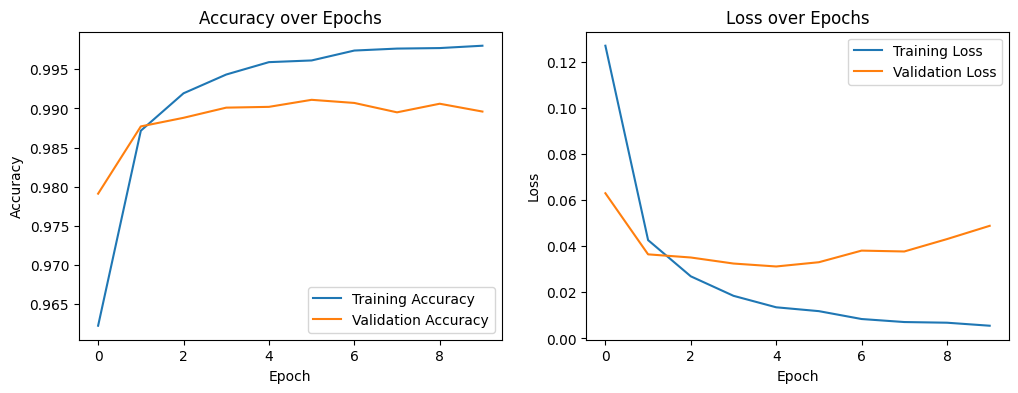

In [17]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


Making Predictions

In [18]:
# Predict on test data
predictions = model.predict(X_test)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Calculate accuracy manually
manual_accuracy = np.mean(predicted_classes == true_classes)
print(f"Manual Test Accuracy: {manual_accuracy}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Manual Test Accuracy: 0.9896


Accuracy Calculation after Training

In [20]:
# Test dataset accuracy
correct_predictions = 0
total_samples = 0

for x_batch, y_batch in test_dataset:
    logits = model(x_batch, training=False)
    predicted_classes = tf.argmax(logits, axis=1)
    true_classes = tf.argmax(y_batch, axis=1)

    correct_predictions += tf.reduce_sum(tf.cast(predicted_classes == true_classes, tf.int32)).numpy()
    total_samples += x_batch.shape[0]

test_accuracy = correct_predictions / total_samples
print(f"Final Test Accuracy: {test_accuracy:.4f}")



Final Test Accuracy: 0.9896


Problem 8 - (Advance assignment) LeNet

In [23]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Load MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Reshape the data to match LeNet's input shape (28x28x1)
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Normalize the images to values between 0 and 1
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# One-hot encode the labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# LeNet model
def lenet():
    model = models.Sequential([
        Input(shape=(28, 28, 1)),  # Define the input shape explicitly
        layers.Conv2D(6, (5, 5), activation='tanh', padding='same'),
        layers.AveragePooling2D((2, 2), strides=2),
        layers.Conv2D(16, (5, 5), activation='tanh'),
        layers.AveragePooling2D((2, 2), strides=2),
        layers.Flatten(),
        layers.Dense(120, activation='tanh'),
        layers.Dense(84, activation='tanh'),
        layers.Dense(10, activation='softmax')  # Output layer for 10 classes
    ])
    return model

# Instantiate the model
model = lenet()

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display model architecture
model.summary()

# Train the model
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_test, y_test))

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc}')


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_4             │ (None, 14, 14, 6)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 10, 10, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_5             │ (None, 5, 5, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 120)            │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 10)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,706 (241.04 KB)

 Trainable params: 61,706 (241.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - accuracy: 0.8238 - loss: 0.6327 - val_accuracy: 0.9537 - val_loss: 0.1500
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - accuracy: 0.9570 - loss: 0.1396 - val_accuracy: 0.9720 - val_loss: 0.0926
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/step - accuracy: 0.9745 - loss: 0.0868 - val_accuracy: 0.9748 - val_loss: 0.0774
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.9804 - loss: 0.0638 - val_accuracy: 0.9788 - val_loss: 0.0639
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.9854 - loss: 0.0480 - val_accuracy: 0.9803 - val_loss: 0.0612
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - accuracy: 0.9886 - loss: 0.0388 - val_accuracy: 0.9835 - val_loss: 0.0518
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - accuracy: 0.9909 - loss: 0.0305 - val_accuracy: 0.9821 - val_loss: 0.0562
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - accuracy: 0.9917 - loss: 0.0276 - 

Problem 9 - (Advance assignment) Survey of famous image recognition models

AlexNet (2012) and VGG16 (2014) are two influential convolutional neural network (CNN) architectures in deep learning, particularly in image classification.

1. AlexNet: Created by Alex Krizhevsky and his team, AlexNet won the 2012 ImageNet competition by significantly outperforming its competitors. The architecture consists of 5 convolutional layers, followed by 3 fully connected layers. It introduced key innovations such as using ReLU (Rectified Linear Unit) for nonlinearity, which helped speed up training, and leveraging GPUs for parallel processing. Additionally, it uses dropout and data augmentation to prevent overfitting. AlexNet is primarily used on datasets like CIFAR-10, and in the original research, it was trained on the ImageNet dataset.

2. VGG16: Proposed by the Visual Geometry Group at Oxford, VGG16 is known for its simplicity and depth. It uses 16 weight layers (13 convolutional and 3 fully connected layers), with small receptive fields (3x3 filters) and max-pooling layers. This design choice makes it deeper than earlier models, which allows it to learn more complex features. VGG16 has become a popular model for transfer learning because of its relatively simple structure and good performance on image recognition tasks. The default input size for VGG16 is 224x224 pixels.

Both architectures are available in Keras' applications module, which provides easy-to-use pretrained models for tasks like image classification and transfer learning. You can specify parameters such as whether to include the fully connected layers (`include_top`), the input shape, and whether to use ImageNet weights.


Problem 10 - Calculation of output size and number of parameters

In [24]:
def conv_layer_params(input_size, filter_size, num_input_channels, num_output_channels, stride=1, padding=0):
    # Calculate output size
    output_size = (input_size - filter_size + 2 * padding) // stride + 1
    # Calculate number of parameters (weights + bias)
    params = (filter_size * filter_size * num_input_channels) * num_output_channels + num_output_channels
    return output_size, params

# Example 1
input_size_1 = 144
filter_size_1 = 3
num_input_channels_1 = 3
num_output_channels_1 = 6
stride_1 = 1
output_size_1, params_1 = conv_layer_params(input_size_1, filter_size_1, num_input_channels_1, num_output_channels_1, stride_1)
print(f"Example 1: Output Size: {output_size_1} x {output_size_1} x {num_output_channels_1}, Params: {params_1}")

# Example 2
input_size_2 = 60
filter_size_2 = 3
num_input_channels_2 = 24
num_output_channels_2 = 48
stride_2 = 1
output_size_2, params_2 = conv_layer_params(input_size_2, filter_size_2, num_input_channels_2, num_output_channels_2, stride_2)
print(f"Example 2: Output Size: {output_size_2} x {output_size_2} x {num_output_channels_2}, Params: {params_2}")

# Example 3
input_size_3 = 20
filter_size_3 = 3
num_input_channels_3 = 10
num_output_channels_3 = 20
stride_3 = 2
output_size_3, params_3 = conv_layer_params(input_size_3, filter_size_3, num_input_channels_3, num_output_channels_3, stride_3)
print(f"Example 3: Output Size: {output_size_3} x {output_size_3} x {num_output_channels_3}, Params: {params_3}")


Example 1: Output Size: 142 x 142 x 6, Params: 168
Example 2: Output Size: 58 x 58 x 48, Params: 10416
Example 3: Output Size: 9 x 9 x 20, Params: 1820


Problem 11 - (Advance assignment) Survey on filter size

Why 3×3 Filters are Commonly Used Instead of Larger Ones like 7×7

3×3 filters are widely used in convolutional neural networks (CNNs) primarily due to their effectiveness in capturing spatial hierarchies with fewer parameters. By using smaller filters (such as 3×3), the network can stack multiple convolutional layers, each with its own small receptive field, to effectively cover a larger area of the image. For example, two consecutive 3×3 filters give a combined receptive field of 5×5, while three consecutive 3×3 filters cover a 7×7 area. This allows the network to build more complex patterns while retaining fewer parameters compared to using a single large filter like 7×7. Additionally, stacking multiple smaller filters introduces more non-linearities (such as activation functions) between layers, which improves the network's ability to learn complex representations.

The Effect of a 1x1 Filter

A 1×1 filter in convolutional layers operates in a manner where it has no spatial dimension in either the height or width direction. Instead, it acts as a channel-wise transformation. The 1×1 filter is used to mix the channels of the input feature map, reducing or expanding the depth of the feature map without affecting the spatial dimensions. This is particularly useful in architectures like the GoogleNet (Inception) model, where 1×1 convolutions allow for efficient dimensionality reduction or expansion while keeping the computational cost low. By applying these small filters, the model can learn to combine features across channels more efficiently, often improving the representational power of the network without the computational burden of larger filters.